In [1]:
%config Completer.use_jedi = False

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

import matplotlib.dates as mdates
import seaborn as sns

In [169]:
class TimeSeriesModel:
    dtypes = {
        'IsCanceled':                                    'float64',
        'LeadTime':                                          'float64',
        'StaysInWeekendNights':                                     'float64',
        'StaysInWeekNights':                                     'float64',
        'Adults':                            'float64',
        'Children':                            'float64',
        'Babies':                                  'float64',
        'Meal':                                    'category',
        'Country':                                               'category',
        'MarketSegment':                                    'category',
        'DistributionChannel':                                       'category',
        'IsRepeatedGuest':                               'float64',
        'PreviousCancellations':                                    'float64',
        'PreviousBookingsNotCanceled':                          'float64',
        'ReservedRoomType':                                             'category',
        'AssignedRoomType':                                            'category',
        'BookingChanges':                                                'float64',
        'DepositType':                                              'category',
        'Agent':                                              'category',
        'Company':                                 'category',
        'DaysInWaitingList':                                           'float64',
        'CustomerType':                                           'category',
        'ADR':                                          'float64',
        'RequiredCarParkingSpaces':                                      'float64',
        'TotalOfSpecialRequests':                                              'float64',
        'ReservationStatus':                                                'category'
        }
    
    ###########
    # Constructor
    ###########
    def __init__(self, path):
        self.data = pd.read_csv(path, dtype=dtypes, converters={'ArrivalDateWeekNumber': '{:0>2}'.format})
        self.df = pd.DataFrame(self.data.sort_values(["ArrivalDateYear", "ArrivalDateWeekNumber"]), columns=["ArrivalDateYear", "ArrivalDateWeekNumber"])
        self.df1 = pd.DataFrame(self.df.ArrivalDateYear.map(str) + self.df.ArrivalDateWeekNumber.map(str), columns=["FullDate"])
        self.df2 = pd.DataFrame(self.data, columns=["IsCanceled"])
        self.df3 = pd.concat([self.df1, self.df2], axis=1)
        self.df4 = self.df3.groupby("FullDate").sum()
        self.ts = self.df4.IsCanceled
        self.num_forecast_steps = 1 * 52
        self.ts_training_data = self.ts[:-self.num_forecast_steps]
        self.ts_dates = np.arange("2015-06-15", "2017-08-27", dtype="datetime64[W]")
        self.ts_loc = mdates.YearLocator(3)
        self.ts_fmt = mdates.DateFormatter("%Y")
        
    def plot_hotel_cancelations(self):
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(self.ts_dates[:-self.num_forecast_steps], self.ts_training_data, lw=2, label="training data")
        ax.xaxis.set_major_locator(self.ts_loc)
        ax.xaxis.set_major_formatter(self.ts_fmt)
        ax.set_ylabel("Cancellations")
        ax.set_xlabel("Date")
        fig.suptitle("Hotel Cancellations",
                     fontsize=15)
        ax.text(0.99, .02,
                "H1 Dataset Hotel Cancellations",
                transform=ax.transAxes,
                horizontalalignment="right",
                alpha=0.5)
        fig.autofmt_xdate()
        plt.show()
        
    def build_model(self):
      trend = sts.LocalLinearTrend(observed_time_series=self.ts_training_data)
      seasonal = tfp.sts.Seasonal(
          num_seasons=52, observed_time_series=self.ts_training_data)
      model = sts.Sum([trend, seasonal], observed_time_series=self.ts_training_data)
      return model
    
    def build_factored_surrogate_posterior(self, ts_model):
        return tfp.sts.build_factored_surrogate_posterior(model=ts_model)
    
    def plot_loss_curve(self, ts_model, variational_posteriors, num_variational_steps):
        optimizer = tf.optimizers.Adam(learning_rate=.1)
        # Using fit_surrogate_posterior to build and optimize the variational loss function.
        @tf.function(experimental_compile=True)
        def train():
          elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
              target_log_prob_fn=ts_model.joint_log_prob(
                  observed_time_series=self.ts_training_data),
              surrogate_posterior=variational_posteriors,
              optimizer=optimizer,
              num_steps=int(num_variational_steps))
          return elbo_loss_curve

        elbo_loss_curve = train()

        plt.plot(elbo_loss_curve)
        plt.title("Loss curve")
        plt.show()
        
    def print_inferred_parameters(self, ts_model, q_samples_tseries_):
        print("Inferred parameters:")
        for param in ts_model.parameters:
          print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_tseries_[param.name], axis=0),
                              np.std(q_samples_tseries_[param.name], axis=0)))
    
    def get_ts_forecast(self, ts_model, q_samples_tseries_):
        return tfp.sts.forecast(model=ts_model,
                                observed_time_series=self.ts_training_data,
                                parameter_samples=q_samples_tseries_,
                                num_steps_forecast=self.num_forecast_steps)
    
    def get_forecast_measures(self, ts_forecast, num_samples):
        tseries_forecast_mean, tseries_forecast_scale, tseries_forecast_samples = (ts_forecast.mean().numpy()[..., 0],
                ts_forecast.stddev().numpy()[..., 0],
                ts_forecast.sample(num_samples).numpy()[..., 0])
        return tseries_forecast_mean, tseries_forecast_scale, tseries_forecast_samples
    
    def plot_forecast(self, x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
      """Plot a forecast distribution against the 'true' time series."""
      colors = sns.color_palette()
      c1, c2 = colors[0], colors[1]
      fig = plt.figure(figsize=(12, 6))
      ax = fig.add_subplot(1, 1, 1)

      num_steps = len(y)
      num_steps_forecast = forecast_mean.shape[-1]
      num_steps_train = num_steps - num_steps_forecast


      ax.plot(x, y, lw=2, color=c1, label='ground truth')

      forecast_steps = np.arange(
          x[num_steps_train],
          x[num_steps_train]+num_steps_forecast,
          dtype=x.dtype)

      ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

      ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
               label='forecast')
      ax.fill_between(forecast_steps,
                       forecast_mean-2*forecast_scale,
                       forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

      ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
      yrange = ymax-ymin
      ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
      ax.set_title("{}".format(title))
      ax.legend()

      if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()

      return fig, ax

    def get_one_step_predictive(self, ts_model, q_samples_tseries_):
        return sts.one_step_predictive(ts_model,
                                       observed_time_series=self.ts,
                                       parameter_samples=q_samples_tseries_)
    
    def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
      """Plot a time series against a model's one-step predictions."""

      colors = sns.color_palette()
      c1, c2 = colors[0], colors[1]

      fig=plt.figure(figsize=(12, 6))
      ax = fig.add_subplot(1,1,1)
      num_timesteps = one_step_mean.shape[-1]
      ax.plot(dates, observed_time_series, label="observed time series", color=c1)
      ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
      ax.fill_between(dates,
                      one_step_mean - one_step_scale,
                      one_step_mean + one_step_scale,
                      alpha=0.1, color=c2)
      ax.legend()

      if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
      fig.tight_layout()
      return fig, ax    

In [159]:
tsm.ts_training_data

FullDate
201527     41.0
201528     48.0
201529     87.0
201530     74.0
201531    101.0
          ...  
201632    124.0
201633    149.0
201634    145.0
201635    118.0
201636    106.0
Name: IsCanceled, Length: 63, dtype: float64

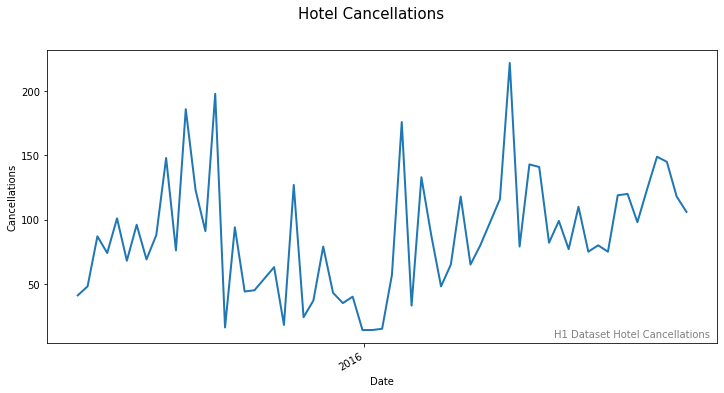

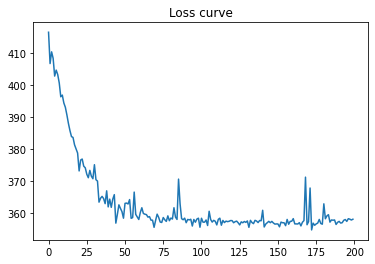

Inferred parameters:
observation_noise_scale: 17.577474198953087 +- 3.0856330627197868
LocalLinearTrend/_level_scale: 0.37987750553072197 +- 0.42690050111347166
LocalLinearTrend/_slope_scale: 0.19126744758765576 +- 0.17215999330254358
Seasonal/_drift_scale: 5.025588386239975 +- 16.276724559045185


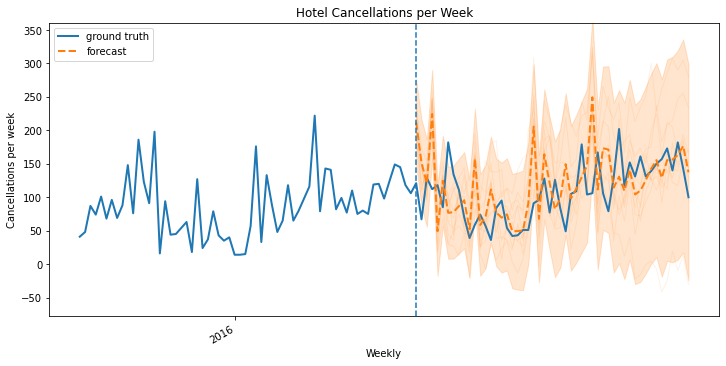

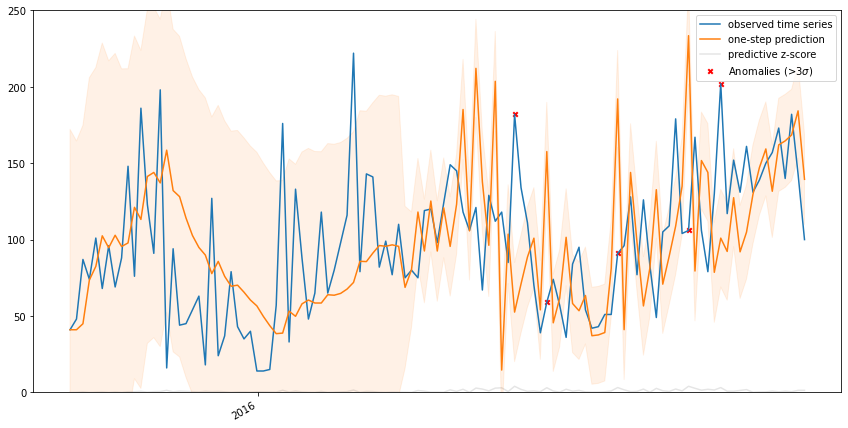

In [171]:
tsm = TimeSeriesModel("/Users/z001hqv/Notebooks/live-project/data/tensor-H1.csv")
tsm.plot_hotel_cancelations()
ts_model = tsm.build_model()
variational_posteriors = tsm.build_factored_surrogate_posterior(ts_model)
tsm.plot_loss_curve(ts_model, variational_posteriors, 200)
q_samples_tseries_ = variational_posteriors.sample(50)
tsm.print_inferred_parameters(ts_model, q_samples_tseries_)
ts_forecast = tsm.get_ts_forecast(ts_model, q_samples_tseries_)
tseries_forecast_mean, tseries_forecast_scale, tseries_forecast_samples = tsm.get_forecast_measures(ts_forecast, 10)

fig, ax = tsm.plot_forecast(
    tsm.ts_dates, tsm.ts,
    tseries_forecast_mean, tseries_forecast_scale, tseries_forecast_samples,
    x_locator=tsm.ts_loc,
    x_formatter=tsm.ts_fmt,
    title="Hotel Cancellations per Week")
ax.axvline(tsm.ts_dates[-tsm.num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Cancellations per week")
ax.set_xlabel("Weekly")
fig.autofmt_xdate()

tseries_one_step_dist = tsm.get_one_step_predictive(ts_model, q_samples_tseries_)
tseries_one_step_mean, tseries_one_step_scale = (
    tseries_one_step_dist.mean().numpy(), tseries_one_step_dist.stddev().numpy())

fig, ax = plot_one_step_predictive(
    tsm.ts_dates, tsm.ts,
    tseries_one_step_mean, tseries_one_step_scale,
    x_locator=tsm.ts_loc, x_formatter=tsm.ts_fmt)
ax.set_ylim(0, 250)

# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((tsm.ts - tseries_one_step_mean) /
                 tseries_one_step_scale)
anomalies = zscores > 3.0
ax.scatter(tsm.ts_dates[anomalies],
           tsm.ts[anomalies],
           c="red", marker="x", s=20, linewidth=2, label=r"Anomalies (>3$\sigma$)")
ax.plot(tsm.ts_dates, zscores, color="black", alpha=0.1, label='predictive z-score')
ax.legend()
plt.show()

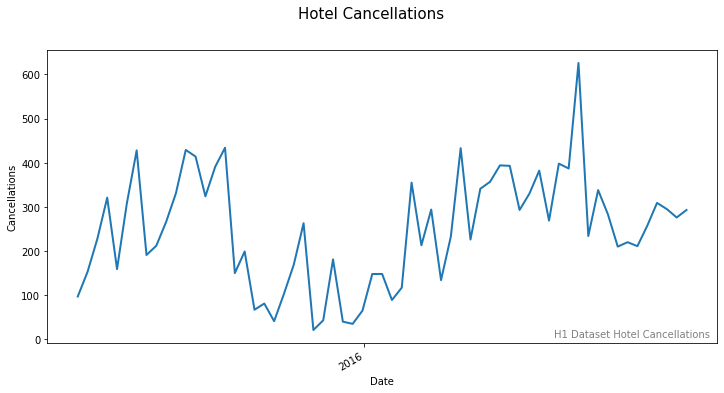

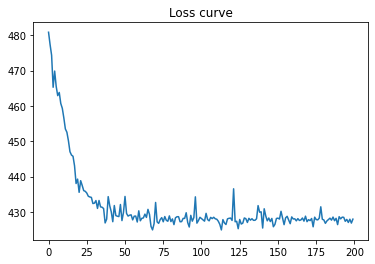

Inferred parameters:
observation_noise_scale: 69.01278041979492 +- 7.674064095964877
LocalLinearTrend/_level_scale: 12.667310709774727 +- 18.992855458526368
LocalLinearTrend/_slope_scale: 1.71268819574066 +- 3.1243062934743744
Seasonal/_drift_scale: 5.927216323117476 +- 12.222725522704238


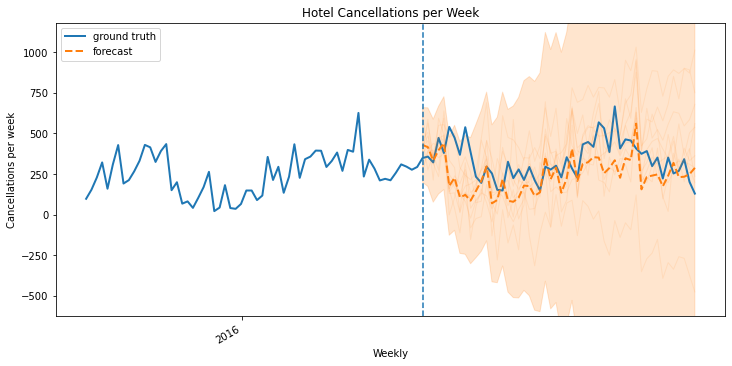

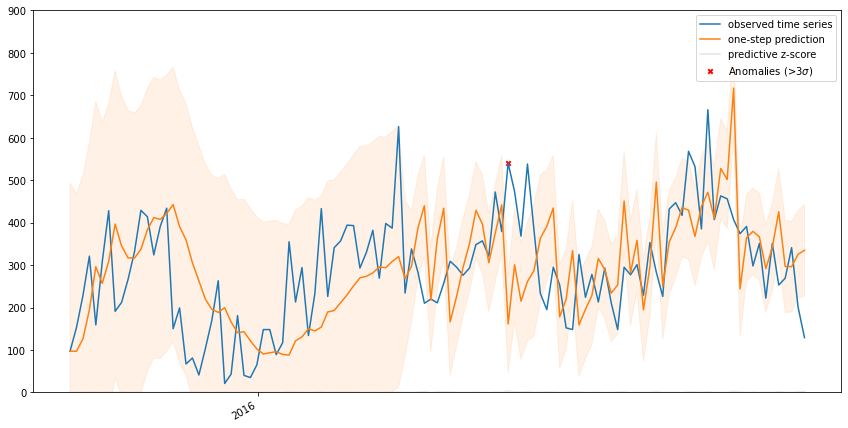

In [170]:
tsm = TimeSeriesModel("/Users/z001hqv/Notebooks/live-project/data/tensor-H2.csv")
tsm.plot_hotel_cancelations()
ts_model = tsm.build_model()
variational_posteriors = tsm.build_factored_surrogate_posterior(ts_model)
tsm.plot_loss_curve(ts_model, variational_posteriors, 200)
q_samples_tseries_ = variational_posteriors.sample(50)
tsm.print_inferred_parameters(ts_model, q_samples_tseries_)
ts_forecast = tsm.get_ts_forecast(ts_model, q_samples_tseries_)
tseries_forecast_mean, tseries_forecast_scale, tseries_forecast_samples = tsm.get_forecast_measures(ts_forecast, 10)

fig, ax = tsm.plot_forecast(
    tsm.ts_dates, tsm.ts,
    tseries_forecast_mean, tseries_forecast_scale, tseries_forecast_samples,
    x_locator=tsm.ts_loc,
    x_formatter=tsm.ts_fmt,
    title="Hotel Cancellations per Week")
ax.axvline(tsm.ts_dates[-tsm.num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Cancellations per week")
ax.set_xlabel("Weekly")
fig.autofmt_xdate()

tseries_one_step_dist = tsm.get_one_step_predictive(ts_model, q_samples_tseries_)
tseries_one_step_mean, tseries_one_step_scale = (
    tseries_one_step_dist.mean().numpy(), tseries_one_step_dist.stddev().numpy())

fig, ax = plot_one_step_predictive(
    tsm.ts_dates, tsm.ts,
    tseries_one_step_mean, tseries_one_step_scale,
    x_locator=tsm.ts_loc, x_formatter=tsm.ts_fmt)
ax.set_ylim(0, 900)

# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((tsm.ts - tseries_one_step_mean) /
                 tseries_one_step_scale)
anomalies = zscores > 3.0
ax.scatter(tsm.ts_dates[anomalies],
           tsm.ts[anomalies],
           c="red", marker="x", s=20, linewidth=2, label=r"Anomalies (>3$\sigma$)")
ax.plot(tsm.ts_dates, zscores, color="black", alpha=0.1, label='predictive z-score')
ax.legend()
plt.show()